In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils
from torch.autograd import Variable

device = torch.device("cuda",0)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

In [2]:
def pred(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
#         print(outputs.argmax(dim=1),
#              outputs.argmax(dim=1)==y,
#              (outputs.argmax(dim=1)==y).float(),
#              (outputs.argmax(dim=1)==y).float().sum(),
#              (outputs.argmax(dim=1)==y).float().sum().item())
        for _ in outputs.argmax(dim=1):
            y_pred.append(int(_))
    return y_pred

def pred_prob(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs:
            y_pred.append(list(map(float, _)))
    return y_pred

class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(4050,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)

In [3]:
import sys
sys.path.append('/home/bis/2021_SJH_detectability/DbyDeep')
from RefModel.model_PepFormer import newModel, evaluate_accuracy, genData

In [4]:
net = newModel().to(device)  # retrained
net.load_state_dict(torch.load(f'/home/bis/2021_SJH_detectability/DbyDeep/log/model_PepFormer.pl')['model'])
net.eval()

newModel(
  (embedding): Embedding(24, 512, padding_idx=0)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=Fals

In [5]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(net)

8867506

In [6]:
df_massive=pd.read_csv('/data/2021_SJH_detectability/data_human/train.csv')
df_merge=pd.DataFrame(df_massive.peptide.unique(), columns=['peptide'])
df_merge['Drop']=True
df_hpp=pd.read_csv('/data/2021_SJH_detectability/data_human/HPP.csv')

# Cross species : Mouse

length > 40: 0
Test AUC : 0.9051168124382081
              precision    recall  f1-score   support

           0     0.9963    0.6713    0.8021   1248306
           1     0.1046    0.9391    0.1882     51018

    accuracy                         0.6818   1299324
   macro avg     0.5504    0.8052    0.4951   1299324
weighted avg     0.9613    0.6818    0.7780   1299324



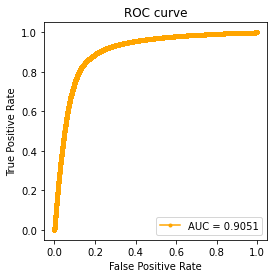

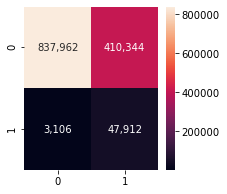

In [7]:
tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 40)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_KLife_PepFormer_fpr.npy', fpr)
np.save('log/result_mouse_KLife_PepFormer_tpr.npy', tpr)
np.save('log/result_mouse_KLife_PepFormer_threshold.npy', threshold)
np.save('log/result_mouse_KLife_PepFormer_prob.npy', probs)
np.save('log/result_mouse_KLife_PepFormer_true.npy', test_label)

length > 40: 0
Test AUC : 0.8778315260492742
              precision    recall  f1-score   support

           0     0.9951    0.6703    0.8010   1085325
           1     0.1073    0.9233    0.1922     46561

    accuracy                         0.6807   1131886
   macro avg     0.5512    0.7968    0.4966   1131886
weighted avg     0.9586    0.6807    0.7760   1131886



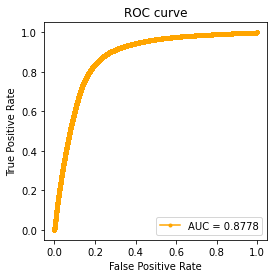

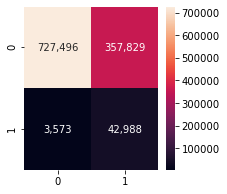

In [8]:
tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 40)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_SkeletaMuscle_PepFormer_fpr.npy', fpr)
np.save('log/result_mouse_SkeletaMuscle_PepFormer_tpr.npy', tpr)
np.save('log/result_mouse_SkeletaMuscle_PepFormer_threshold.npy', threshold)
np.save('log/result_mouse_SkeletaMuscle_PepFormer_prob.npy', probs)
np.save('log/result_mouse_SkeletaMuscle_PepFormer_true.npy', test_label)

# Cross species : Human

length > 40: 0
Test AUC : 0.8569953458488135
              precision    recall  f1-score   support

           0     0.9927    0.7017    0.8222   1363828
           1     0.0985    0.8637    0.1769     51481

    accuracy                         0.7076   1415309
   macro avg     0.5456    0.7827    0.4996   1415309
weighted avg     0.9602    0.7076    0.7988   1415309



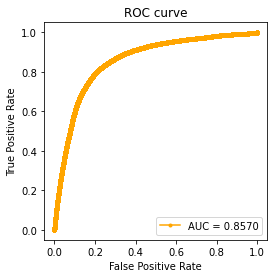

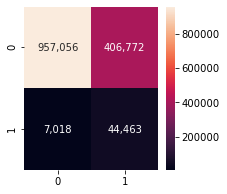

In [9]:
tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 40)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_HEK293_PepFormer_fpr.npy', fpr)
np.save('log/result_human_HEK293_PepFormer_tpr.npy', tpr)
np.save('log/result_human_HEK293_PepFormer_threshold.npy', threshold)
np.save('log/result_human_HEK293_PepFormer_prob.npy', probs)
np.save('log/result_human_HEK293_PepFormer_true.npy', test_label)

length > 40: 0
Test AUC : 0.8041547437809393
              precision    recall  f1-score   support

           0     0.9936    0.6955    0.8182   1003489
           1     0.0490    0.7773    0.0922     20251

    accuracy                         0.6971   1023740
   macro avg     0.5213    0.7364    0.4552   1023740
weighted avg     0.9749    0.6971    0.8039   1023740



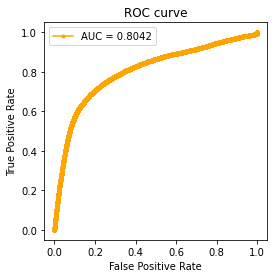

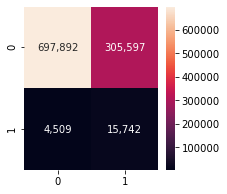

In [10]:
tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 40)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_HmapLiver_PepFormer_fpr.npy', fpr)
np.save('log/result_human_HmapLiver_PepFormer_tpr.npy', tpr)
np.save('log/result_human_HmapLiver_PepFormer_threshold.npy', threshold)
np.save('log/result_human_HmapLiver_PepFormer_prob.npy', probs)
np.save('log/result_human_HmapLiver_PepFormer_true.npy', test_label)

# Cross species : Yeast

length > 40: 0
Test AUC : 0.8612821361905629
              precision    recall  f1-score   support

           0     0.9921    0.6429    0.7802    520819
           1     0.1402    0.9194    0.2432     32972

    accuracy                         0.6594    553791
   macro avg     0.5661    0.7811    0.5117    553791
weighted avg     0.9414    0.6594    0.7483    553791



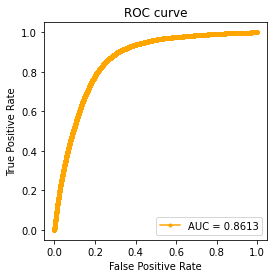

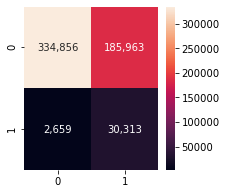

In [11]:
tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 40)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_DelPBP1_PepFormer_fpr.npy', fpr)
np.save('log/result_yeast_DelPBP1_PepFormer_tpr.npy', tpr)
np.save('log/result_yeast_DelPBP1_PepFormer_threshold.npy', threshold)
np.save('log/result_yeast_DelPBP1_PepFormer_prob.npy', probs)
np.save('log/result_yeast_DelPBP1_PepFormer_true.npy', test_label)

length > 40: 0
Test AUC : 0.9050583326423864
              precision    recall  f1-score   support

           0     0.9844    0.6865    0.8089    561781
           1     0.2904    0.9220    0.4417     78156

    accuracy                         0.7153    639937
   macro avg     0.6374    0.8043    0.6253    639937
weighted avg     0.8997    0.7153    0.7641    639937



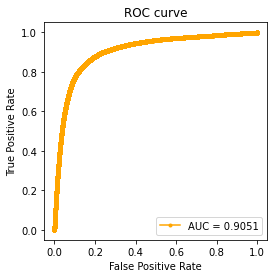

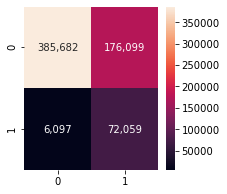

In [12]:
tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 40)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_KLife_PepFormer_fpr.npy', fpr)
np.save('log/result_yeast_KLife_PepFormer_tpr.npy', tpr)
np.save('log/result_yeast_KLife_PepFormer_threshold.npy', threshold)
np.save('log/result_yeast_KLife_PepFormer_prob.npy', probs)
np.save('log/result_yeast_KLife_PepFormer_true.npy', test_label)